In [1]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import statistics
import itertools
from subprocess import call
from IPython.display import Image
# plotting libraries
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
# sklearn libraries
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [3]:
#%% import the data into a pandas dataframe

df = pd.read_csv('Datasets/df_prepped.csv')

In [4]:
# Print some information about the data

print('There are '+ str(len(df)) + ' data entries\n')
print('Min Ambient Temperature is ' + str(df['Ambient Temperature'].values.min())+'\n')
print('Max Ambient Temperature is ' + str(df['Ambient Temperature'].values.max())+'\n')
print('Std Ambient Temperature is ' + str(df['Ambient Temperature'].values.std())+'\n')
print('Min Ambient Humidity is ' + str(df['Ambient Humidity'].values.min())+'\n')
print('Max Ambient Humidity is ' + str(df['Ambient Humidity'].values.max())+'\n')
print('Std Ambient Humidity is ' + str(df['Ambient Humidity'].values.std())+'\n')
print('Min Leaf Temperature Differential is ' + str(df['Leaf Temperature Differential'].values.min())+'\n')
print('Max Leaf Temperature Differential is ' + str(df['Leaf Temperature Differential'].values.max())+'\n')
print('Mean Leaf Temperature Differential is ' + str(df['Leaf Temperature Differential'].values.mean())+'\n')

There are 805 data entries

Min Ambient Temperature is 23.4

Max Ambient Temperature is 41.97

Std Ambient Temperature is 3.2823937955594182

Min Ambient Humidity is 34.719

Max Ambient Humidity is 76.646

Std Ambient Humidity is 9.00589183215784

Min Leaf Temperature Differential is -10.97

Max Leaf Temperature Differential is 6.66

Mean Leaf Temperature Differential is -4.285552795031056



In [5]:
#%% calculate required variables 

# leaf temperature 
df['ltemp'] = df['Ambient Temperature'] + df['Leaf Temperature Differential']

#%% define the target variable and the predictors

# define the variable for prediction
y = df['ltemp']

# define the dataframe of predictor variables 
X = df.drop(['ltemp', 'Leaf Temperature Differential'], axis = 1)

# create list of random numbers 
rnumbers = list(np.random.randint(1,1000, size=X.shape[0]))

# create dataframe for feature selection purposes only including a column of random numbers
X_features = X
X_features['random_numbers'] = rnumbers

In [6]:
# Set random seed to ensure "reproducible" runs
RSEED = 50
# X_2f
X_1f = np.zeros((805,2))
X_1f[:,0] = np.array(X['Ambient Temperature'])
X_1f[:,1] = np.array(X['Ambient Humidity'])
N=800
X_1f=X_1f[0:N,:]
# label classes for simplicty split into two classes low or high
yy=pd.DataFrame()
yy['vals']=y[0:N]
yy['label']=pd.qcut(yy.vals.values, 2, labels=[0, 1])
yy['strlabel']=''
yy.strlabel[yy.label==1]='high'
yy.strlabel[yy.label==0]='low'

Text(0.5, 1.0, 'Leaf Temp')

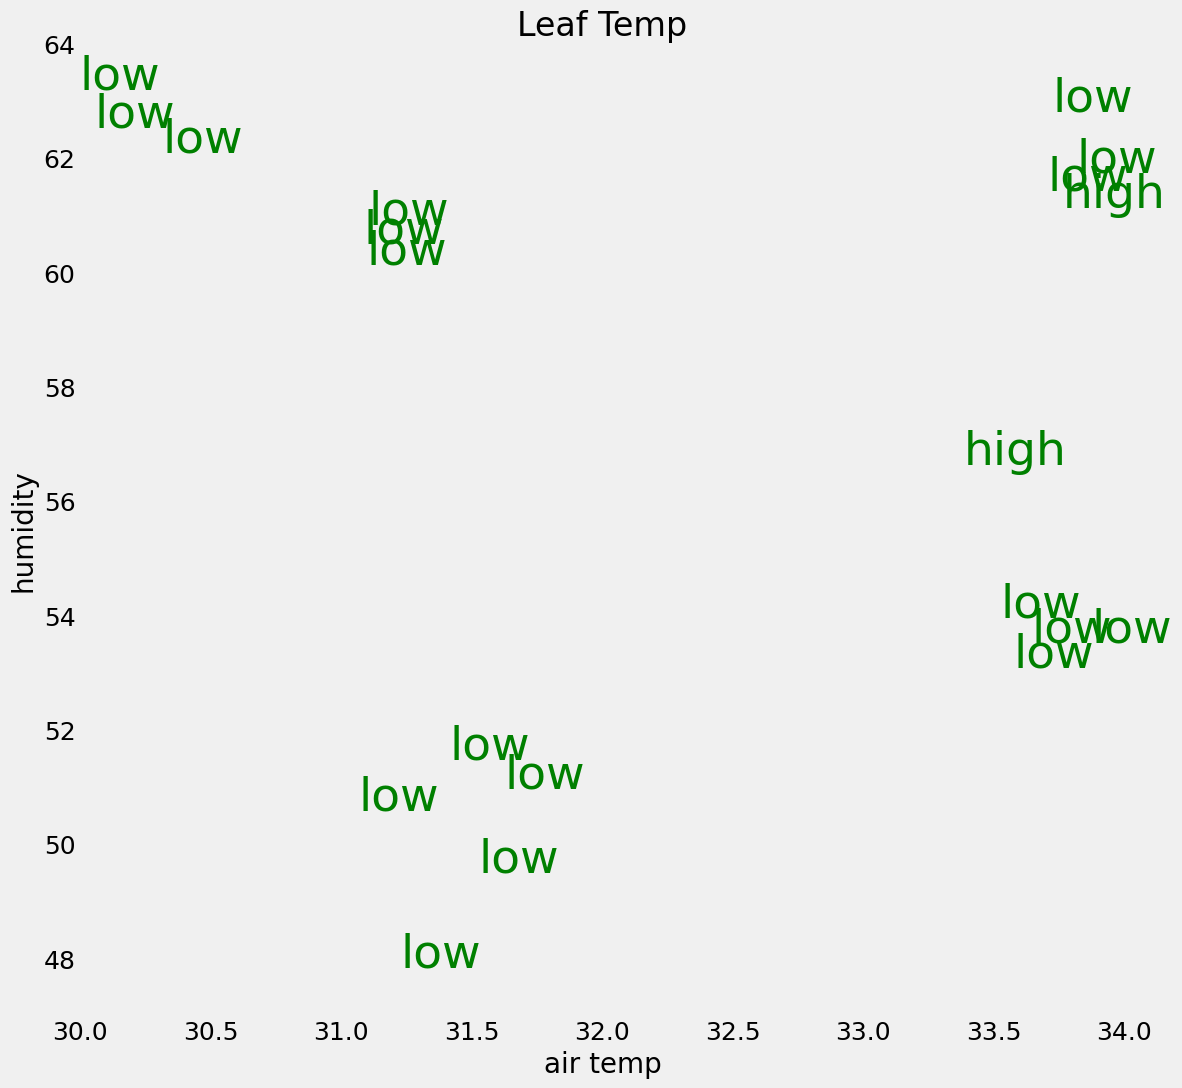

In [7]:
# Plot data?
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))

# Plot a subset each point as the label
for x1, x2, label in zip(X_1f[0:20, 0], X_1f[0:20, 1], yy.strlabel[0:20].values):
    plt.text(x1, x2, label, fontsize = 34, color = 'g',
             ha='center', va='center')
    
# Plot formatting
plt.grid(None);
plt.xlim((30, 34));
plt.ylim((47, 64));
plt.xlabel('air temp', size = 20); plt.ylabel('humidity', size = 20); plt.title('Leaf Temp', size = 24)

In [21]:
# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED)

In [28]:
# After runnning the follow cells try seeing the effect of limiting the max depth
# uncomment below code - you can play around with altering max depth to see the limits

tree = DecisionTreeClassifier(max_depth=15, random_state=RSEED)

In [29]:
tree.fit(X_1f, yy.label.values)

DecisionTreeClassifier(max_depth=15, random_state=50)

In [30]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'Model Accuracy: {tree.score(X_1f, yy.label.values )}')

Decision tree has 293 nodes with maximum depth 15.
Model Accuracy: 0.99375


In [31]:
# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(X_1f,yy.label.values , 
                                                          stratify = yy.label.values,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [32]:
# Features for feature importances
features = ['Ambient Temperature','Ambient Humidity']

In [34]:
# Save tree as dot file
export_graphviz(tree, 'tree_example.dot', rounded = True, 
                feature_names = features, max_depth=6,
                class_names = ['high leaf temp', 'low leaf temp'], filled = True)

# Unlimitted graphviz
# export_graphviz(tree, 'tree_example.dot', rounded = True, feature_names = features,  class_names = ['high leaf temp', 'low leaf temp'], filled = True)

# Convert to png
try:
    call(['dot', '-Tpng', 'tree_example.dot', '-o', 'tree_example.png', '-Gdpi=200'])
except:
    print('graphviz failed')
    print('Loaded the max depth limited figure pre-produced incase of graphviz failure \n')
    print('If you would like to see the results having limited the max depth please uncomment the last line in this cell')

    
Image(filename='tree_example.png')
Image(filename='tree_example_max_depth_4.png')

graphviz failed
Loaded the max depth limited figure pre-produced incase of graphviz failure 

If you would like to see the results having limited the max depth please uncomment the last line in this cell


FileNotFoundError: [Errno 2] No such file or directory: 'tree_example.png'

In [35]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 217 nodes with maximum depth 15.


In [36]:
# Will over fit
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [37]:
print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 0.9999425954510084
Test ROC AUC  Score: 0.8236683102993264


Recall Baseline: 1.0 Test: 0.83 Train: 1.0
Precision Baseline: 0.5 Test: 0.82 Train: 1.0
Roc Baseline: 0.5 Test: 0.82 Train: 1.0


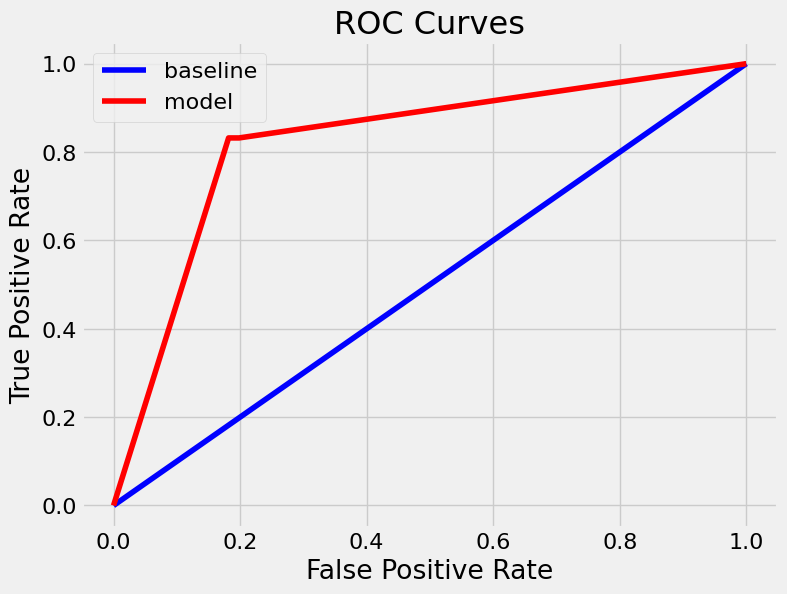

In [38]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
evaluate_model(predictions, probs, train_predictions, train_probs)

In [39]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
0,Ambient Temperature,0.68463
1,Ambient Humidity,0.31537


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[99 22]
 [20 99]]


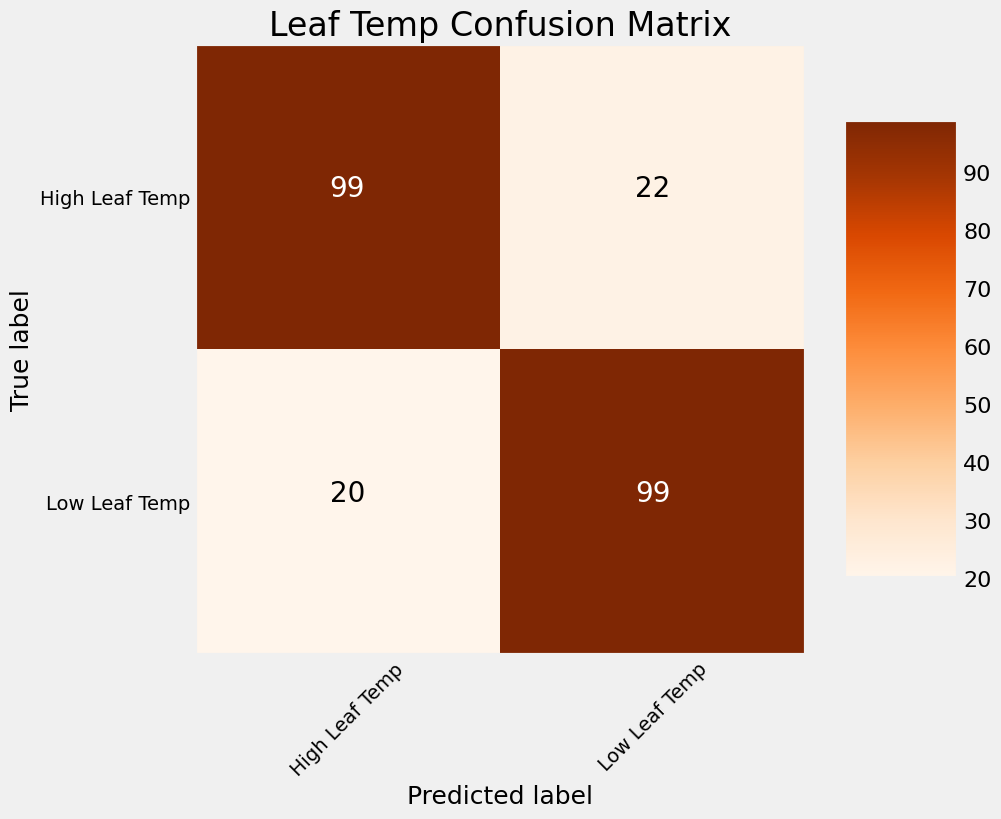

In [41]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['High Leaf Temp', 'Low Leaf Temp'],
                      title = 'Leaf Temp Confusion Matrix')

# plot_confusion_matrix(cm,  normalize=True, classes = ['High Leaf Temp', 'Low Leaf Temp'], title = 'Leaf Temp Confusion Ma

In [42]:
# conduct sensitivity test on max depth

# seed 
SEED = 1

# range of tree depths
mds = np.arange(1,30)

# list for evaluation
r2_sens_lst_md = []
rmse_sens_lst_md = []

# loop over all values for maximum depth between 1 and 30, storing the r2 and rmse for 10 fold cross validation
for i in range(len(mds)):
    md = mds[i]
    rf_sens = RandomForestRegressor(max_features = 3, random_state=SEED, n_estimators = 100, max_depth = md)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    r2s_sens = list(cross_val_score(rf_sens, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
    rmses_sens = list(cross_val_score(rf_sens, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise'))
    r2_sens = statistics.mean(r2s_sens)
    rmse_sens = statistics.mean(rmses_sens)
    r2_sens_lst_md.append(r2_sens)
    rmse_sens_lst_md.append(rmse_sens)

In [43]:
# max depth dataframe 
df_sens_md = pd.DataFrame({'max_depth' : list(mds), 'r2' : r2_sens_lst_md, 'rmse' : rmse_sens_lst_md})
df_sens_md['rmse'] = df_sens_md['rmse']*-1

Text(0.5, 1.0, 'max depth vs. r2')

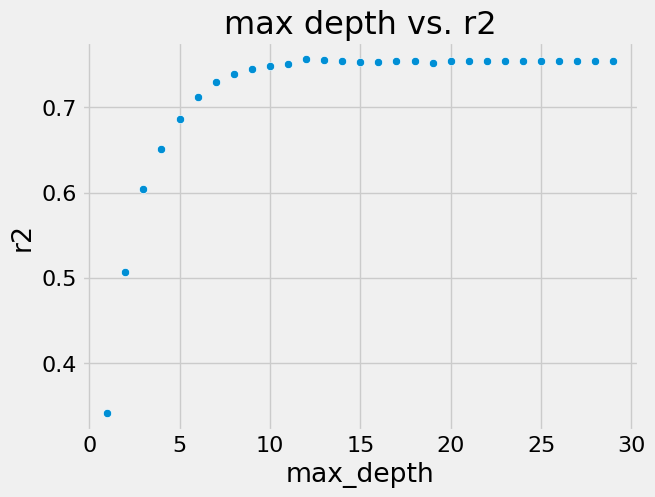

In [44]:
# scatterplot for maximum depth vs.performance metric (change 'r2' for 'rmse' to replicate the plots in the presentation)
sns.scatterplot(x = 'max_depth', y = 'r2', data = df_sens_md)
plt.title('max depth vs. r2')

In [45]:
#%% conduct sensitivity test on number of parameters to split

# range of parameters
mxf = np.arange(1,9)

# list for evaluation
r2_sens_lst_mxf = []
rmse_sens_lst_mxf = []

# loop over all values for maximum number of features used in splitting between 1 and 9, storing the r2 and rmse for 10 fold cross validation
for i in range(len(mxf)):
    mx = mxf[i]
    rf_sens = RandomForestRegressor(max_features = mx, random_state=SEED, n_estimators = 100)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    r2s_sens = list(cross_val_score(rf_sens, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
    rmses_sens = list(cross_val_score(rf_sens, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise'))
    r2_sens = statistics.mean(r2s_sens)
    rmse_sens = statistics.mean(rmses_sens)
    r2_sens_lst_mxf.append(r2_sens)
    rmse_sens_lst_mxf.append(rmse_sens)

# max depth dataframe 
df_sens_mxf = pd.DataFrame({'max_features' : list(mxf), 'r2' : r2_sens_lst_mxf, 'rmse' : rmse_sens_lst_mxf})
df_sens_mxf['rmse'] = df_sens_mxf['rmse']*-1

Text(0.5, 1.0, 'max features vs. r2')

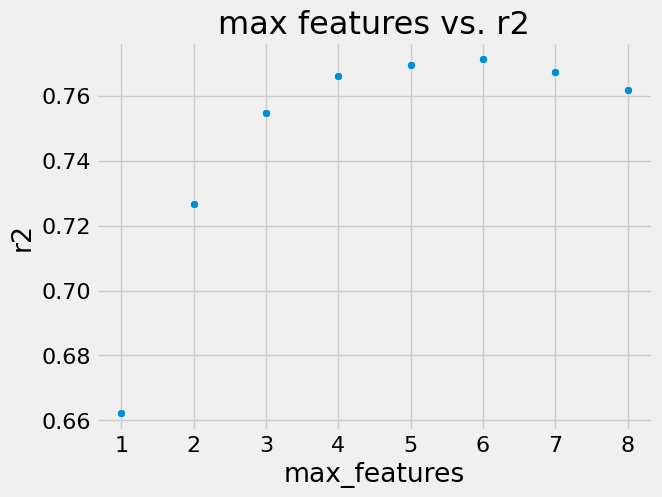

In [46]:
# scatterplot for maximum number of features vs.performance metric (change 'r2' for 'rmse' to replicate the plots in the presentation)
sns.scatterplot(x = 'max_features', y = 'r2', data = df_sens_mxf)
plt.title('max features vs. r2')

In [47]:
#%% Evaluate the performance of the Random Forest Algorithm with chosen parameters from the sensitivity analysis using cross validation 

# instantiate the random forest regressor
rf = RandomForestRegressor(max_features = 5, random_state=SEED, n_estimators = 100, max_depth = 25)

In [48]:
# set up the cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [49]:
# calculate the metrics for each kfold cross validation
r2s = list(cross_val_score(rf, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
rmses = list(cross_val_score(rf, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise'))

# take the mean of these 
r2 = statistics.mean(r2s)
rmse = statistics.mean(rmses)

print('mean r2 = '+ str(r2))
print('mean rmse = '+ str(-1*rmse))

mean r2 = 0.7697291175076764
mean rmse = 1.4926956252068984


In [ ]:
#%% calculate the feature importances 

# fit the random forest regressor with the dataframe of predictor variables that includes the column of random numbers for comparison
rf.fit(X_features, y)

# feature importances
importance = rf.feature_importances_

# features
features = list(X_features.columns)

# dataframe for plotting 
df_features = pd.DataFrame(list(zip(importance, features)), 
               columns =['importance', 'features'])
